# Transformaciones, Analisis de Dimension y Limpieza de Datos

### Importación de Librerías para el Análisis de Multicolinealidad

En esta sección se importan las librerías necesarias para realizar el análisis de multicolinealidad en el conjunto de datos. Estas herramientas permiten calcular el Factor de Inflación de la Varianza (VIF), lo que es esencial para identificar y tratar la multicolinealidad entre las variables predictoras.

In [22]:
import pandas as pd
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Carga del Conjunto de Datos

Cargamos el conjunto de datos que contiene la encuesta de satisfacción del cliente. Este paso es fundamental para iniciar cualquier proceso de análisis y manipulación de datos.


In [4]:
# Cargar los datos
data = pd.read_csv(r'C:\Users\pc-admin\Documents\Proyectos Data\Customer_Satisfaction\Encuesta.csv')
data


,Unnamed: 0,Gender,customer_type,age,type_of_travel,customer_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,...,inflight_entertainment,onboard_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,39463,Female,disloyal Customer,46,Business travel,Eco,406,3,0,4,...,5,1,5,4,2,4,5,0,17.0,neutral or dissatisfied
1,39464,Male,Loyal Customer,24,Business travel,Eco,479,4,3,3,...,4,2,2,1,4,1,4,0,0.0,neutral or dissatisfied
2,39467,Male,Loyal Customer,63,Business travel,Business,2009,2,3,3,...,2,2,2,2,3,2,2,0,30.0,neutral or dissatisfied
3,39470,Male,Loyal Customer,38,Business travel,Business,1984,1,4,5,...,1,1,2,1,1,1,4,2,0.0,neutral or dissatisfied
4,39471,Female,Loyal Customer,35,Personal Travel,Eco,2288,1,3,2,...,3,2,1,4,2,4,3,0,0.0,neutral or dissatisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71887,129875,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,...,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
71888,129876,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,...,4,4,5,5,5,5,4,0,0.0,satisfied
71889,129877,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,...,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
71890,129878,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,...,4,3,2,5,4,5,4,0,0.0,satisfied


### Visualización del Número de Valores No Nulos por Variable con Identificación de Nulos

Este código genera un gráfico de barras que muestra el número de valores no nulos para cada variable en el DataFrame. Además, utiliza un esquema de color para resaltar las variables que contienen valores nulos, facilitando la identificación visual de posibles problemas en los datos.

#### Descripción del Código:

- **Contar Valores No Nulos**: Se utiliza `data.notnull().sum()` para contar el número de valores no nulos en cada columna del DataFrame.
  
- **Identificación de Columnas con Nulos**: Se calcula el número total de filas en el DataFrame (`total_rows`) y se compara con el número de valores no nulos por columna. Si una columna tiene menos valores no nulos que el total de filas, se asigna un color diferente ('salmon') para indicarla.

- **Lista de Colores**: Se crea una lista de colores donde:
  - **'teal'** indica que la columna no tiene valores nulos.
  - **'salmon'** indica que la columna tiene uno o más valores nulos.


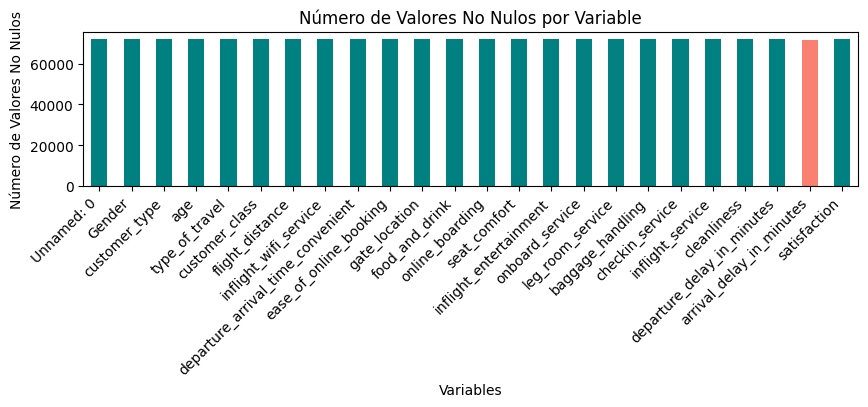

In [10]:
# Contar el número de valores no nulos por columna
non_null_counts = data.notnull().sum()

# Calcular el número total de filas en el DataFrame
total_rows = data.shape[0]

# Crear una lista de colores: 'teal' para columnas sin nulos, 'salmon' para columnas con nulos
colors = ['salmon' if non_null_counts[col] < total_rows else 'teal' for col in data.columns]

# Crear el gráfico de barras
plt.figure(figsize=(10, 2))
non_null_counts.plot(kind='bar', color=colors)
plt.title('Número de Valores No Nulos por Variable')
plt.xlabel('Variables')
plt.ylabel('Número de Valores No Nulos')
plt.xticks(rotation=45, ha='right')
plt.show()



### Visualización del Número de Valores Nulos por Variable

Este código genera un gráfico de barras que muestra la cantidad de valores nulos presentes en cada variable del DataFrame. Esta visualización es útil para identificar rápidamente cuáles variables tienen datos faltantes y la magnitud de estos faltantes.


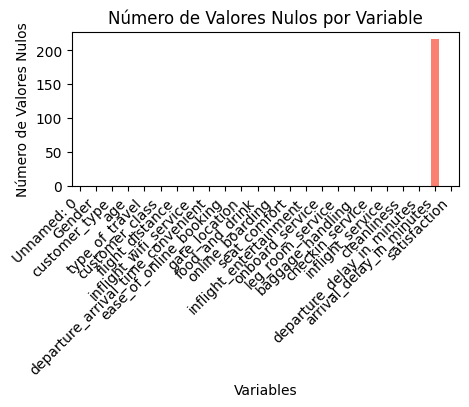

In [11]:
# Contar el número de valores nulos por columna
null_counts = data.isnull().sum()

# Crear el gráfico de barras
plt.figure(figsize=(5, 2))
null_counts.plot(kind='bar', color='salmon')
plt.title('Número de Valores Nulos por Variable')
plt.xlabel('Variables')
plt.ylabel('Número de Valores Nulos')
plt.xticks(rotation=45, ha='right')
plt.show()


# Identificación y Manejo de Valores Nulos

Uno de los primeros pasos en el proceso de limpieza de datos es identificar y manejar los valores nulos. Aquí, se calcula la cantidad total de filas en el DataFrame, se identifican los valores nulos en cada columna y se decide cómo tratarlos según su proporción.


Para empezar, se cuenta el número total de filas en el DataFrame. Este valor es necesario para calcular el porcentaje de valores nulos en cada columna. Se ha establecido como umbral el 0.5% asi:

- Eliminar filas con valores nulos si el porcentaje es menor o igual a 0.5%
- Imputar valores nulos con la mediana de los últimos 10 registros si el porcentaje es mayor a 0.5%


In [35]:
# Calcular el total de filas
total_filas = len(data)

# Identificar y mostrar valores nulos junto con su porcentaje correspondiente
valores_nulos = data.isnull().sum()
porcentaje_nulos = (valores_nulos / total_filas) * 100

# Crear un DataFrame para mostrar ambos resultados
nulos_df = pd.DataFrame({
    'Valores Nulos': valores_nulos,
    'Porcentaje Nulos (%)': porcentaje_nulos
})

# Imprimir el resumen de valores nulos
print("Valores nulos y su porcentaje por columna:")
print(nulos_df)

# Manejo de los valores nulos basado en el porcentaje
for columna, porcentaje in porcentaje_nulos.items():
    if porcentaje > 0:  # Si la columna tiene valores nulos
        if porcentaje <= 0.5:
            # Eliminar filas con valores nulos si el porcentaje es menor o igual a 0.5%
            data = data.dropna(subset=[columna])
            print(f"Filas con valores nulos en '{columna}' eliminadas.")
        else:
            # Imputar valores nulos con la mediana de los últimos 10 registros si el porcentaje es mayor a 0.5%
            median_columna = data[columna].dropna().tail(10).median()
            if pd.api.types.is_integer_dtype(data[columna]):
                median_columna = int(median_columna)  # Asegurarnos de que la mediana sea un entero si corresponde
            data[columna] = data[columna].fillna(median_columna)
            print(f"Valores nulos en '{columna}' imputados con la mediana de los últimos 10 registros.")


Valores nulos y su porcentaje por columna:
                                   Valores Nulos  Porcentaje Nulos (%)
Unnamed: 0                                     0              0.000000
Gender                                         0              0.000000
customer_type                                  0              0.000000
age                                            0              0.000000
type_of_travel                                 0              0.000000
customer_class                                 0              0.000000
flight_distance                                0              0.000000
inflight_wifi_service                          0              0.000000
departure_arrival_time_convenient              0              0.000000
ease_of_online_booking                         0              0.000000
gate_location                                  0              0.000000
food_and_drink                                 0              0.000000
online_boarding                   

# Eliminación de Columnas No Relevantes

En algunos casos, los conjuntos de datos incluyen columnas que no aportan valor al análisis. Este paso elimina una de esas columnas.

### Eliminación de la Columna 'Unnamed: 0'

La columna `Unnamed: 0` se genera a veces automáticamente cuando se guarda o carga un archivo CSV. Esta columna generalmente representa un índice adicional y no es necesaria para el análisis, por lo que se procede a eliminarla.


In [36]:
data = data.drop('Unnamed: 0', axis=1)


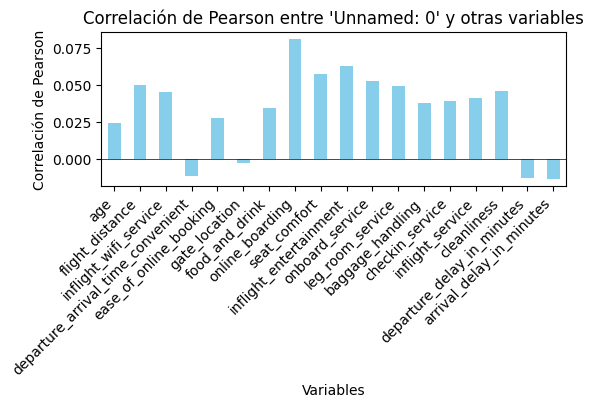

In [15]:
# Filtrar las columnas numéricas
numeric_data = data.select_dtypes(include=['number'])

# Verificar si la columna 'Unnamed: 0' existe en el DataFrame numérico
if 'Unnamed: 0' in numeric_data.columns:
    # Calcular la matriz de correlación de Pearson solo con las columnas numéricas
    correlation_matrix = numeric_data.corr()

    # Extraer la fila de correlaciones para la columna 'Unnamed: 0'
    correlation_with_unnamed = correlation_matrix['Unnamed: 0']

    # Crear el gráfico de barras para mostrar la correlación
    plt.figure(figsize=(6, 2))
    correlation_with_unnamed.drop(labels=['Unnamed: 0']).plot(kind='bar', color='skyblue')
    plt.title("Correlación de Pearson entre 'Unnamed: 0' y otras variables")
    plt.xlabel("Variables")
    plt.ylabel("Correlación de Pearson")
    plt.axhline(0, color='black', linewidth=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("La columna 'Unnamed: 0' no se encuentra en el DataFrame numérico.")



Gráfico que representa la correlación de Pearson entre la columna `Unnamed: 0` y otras variables numéricas en el conjunto de datos:

Como se puede observar en el gráfico, las correlaciones entre `Unnamed: 0` y las demás variables son muy bajas, con valores que oscilan alrededor de 0.0. La mayoría de las correlaciones están justo por encima de 0.0, con algunas incluso ligeramente negativas, como en el caso de las variables relacionadas con el retraso en la llegada (`arrival_delay_in_minutes`).

Estas correlaciones bajas y cercanas a cero sugieren que la columna `Unnamed: 0` no tiene una relación significativa con las otras variables numéricas en el conjunto de datos. Por lo tanto, es probable que `Unnamed: 0` no aporte valor predictivo en modelos que intenten explicar o predecir otras variables.

# Codificación de Variables Categóricas y Conversión de Tipos

Este bloque de código se centra en preparar el conjunto de datos para el modelado mediante la codificación de variables categóricas, la conversión de columnas booleanas a numéricas, y la optimización de los tipos de datos numéricos. Estos pasos son esenciales para asegurar que los datos estén en un formato adecuado para el análisis estadístico y la modelización.

### Codificación de Variables Categóricas

Primero, codificamos la columna `satisfaction` en valores binarios, donde `1` representa satisfacción y `0` insatisfacción. Luego, se aplican técnicas de One-Hot Encoding a otras variables categóricas, transformando cada categoría en una columna binaria.


In [16]:
# Codificar las variables categóricas usando One-Hot Encoding, incluyendo la columna 'satisfaction'
data['satisfaction'] = data['satisfaction'].apply(lambda x: 1 if x.strip() == 'satisfied' else 0)
data = pd.get_dummies(data, columns=['Gender', 'customer_type', 'type_of_travel', 'customer_class'], drop_first=True)

# Convertir columnas booleanas a números (0 y 1) usando apply y map
data = data.apply(lambda col: col.map({True: 1, False: 0}) if col.dtype == 'bool' else col)

# Asegurar la consistencia de tipos de datos numéricos
# Convertir todas las columnas numéricas optimizadas a tipos estándar y asegurar que sean numéricas
columnas_numericas = data.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
data[columnas_numericas] = data[columnas_numericas].apply(pd.to_numeric, downcast='integer')

# Verificación y Validación
# Verificar la estructura final del DataFrame
print("\nEstructura final del DataFrame después de todas las transformaciones:")
print(data.info())



Estructura final del DataFrame después de todas las transformaciones:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71892 entries, 0 to 71891
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         71892 non-null  int32  
 1   age                                71892 non-null  int8   
 2   flight_distance                    71892 non-null  int16  
 3   inflight_wifi_service              71892 non-null  int8   
 4   departure_arrival_time_convenient  71892 non-null  int8   
 5   ease_of_online_booking             71892 non-null  int8   
 6   gate_location                      71892 non-null  int8   
 7   food_and_drink                     71892 non-null  int8   
 8   online_boarding                    71892 non-null  int8   
 9   seat_comfort                       71892 non-null  int8   
 10  inflight_entertainment             71892 non-nu

# Verificación de la Codificación de Variables Categóricas

Después de realizar la codificación de las variables categóricas, es crucial verificar que los datos se hayan transformado correctamente. Este paso asegura que la columna `satisfaction` esté codificada solo con valores 0 y 1, y que las variables categóricas codificadas tengan una distribución lógica de valores.

### Verificación de la Codificación de 'satisfaction'

Primero, comprobamos que la columna `satisfaction` contiene únicamente los valores esperados (0 y 1). Esto confirma que la codificación binaria se ha realizado correctamente.


In [38]:
# Verificar que 'satisfaction' esté correctamente codificada y que solo tenga valores 0 y 1
print("\nVerificación de la columna 'satisfaction':")
print(data['satisfaction'].unique())

# Verificar la distribución de las variables categóricas codificadas
for col in ['Gender_Male', 'customer_type_disloyal Customer', 'type_of_travel_Personal Travel', 'customer_class_Eco', 'customer_class_Eco Plus']:
    print(f"Distribución de valores en '{col}':")
    print(data[col].value_counts())
    print("\n")


Verificación de la columna 'satisfaction':
[0 1]
Distribución de valores en 'Gender_Male':
Gender_Male
0    36285
1    35391
Name: count, dtype: int64


Distribución de valores en 'customer_type_disloyal Customer':
customer_type_disloyal Customer
0    58375
1    13301
Name: count, dtype: int64


Distribución de valores en 'type_of_travel_Personal Travel':
type_of_travel_Personal Travel
0    48848
1    22828
Name: count, dtype: int64


Distribución de valores en 'customer_class_Eco':
customer_class_Eco
0    38787
1    32889
Name: count, dtype: int64


Distribución de valores en 'customer_class_Eco Plus':
customer_class_Eco Plus
0    66428
1     5248
Name: count, dtype: int64




### Visualización de la Distribución de Variables Categóricas Codificadas

El siguiente código tiene como objetivo visualizar la distribución de varias columnas categóricas codificadas en el conjunto de datos. En lugar de simplemente mostrar los números de conteo para cada categoría, este enfoque utiliza gráficos de barras horizontales compactos que muestran tanto la cantidad como la proporción de cada categoría.


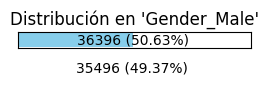

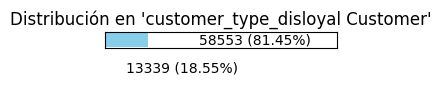

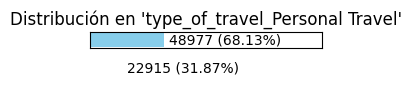

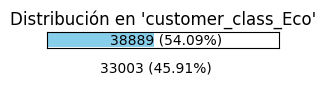

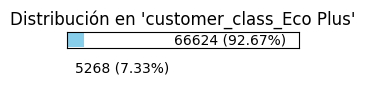

In [20]:
# Lista de columnas categóricas codificadas
columns = ['Gender_Male', 'customer_type_disloyal Customer', 'type_of_travel_Personal Travel', 'customer_class_Eco', 'customer_class_Eco Plus']

# Crear gráficos pequeños de barras para cada columna
for col in columns:
    # Obtener el conteo de valores
    counts = data[col].value_counts()
    
    # Normalizar los valores para obtener proporciones
    proportions = counts / counts.sum()
    
    # Crear una figura pequeña
    plt.figure(figsize=(3, 0.2))  # Ajusta el tamaño según tus necesidades
    
    # Crear barras horizontales pequeñas
    plt.barh(y=col, width=proportions[1], color='skyblue', height=0.5)
    
    # Agregar el texto con el número y la proporción
    for i in range(len(proportions)):
        plt.text(proportions[i]/2, i, f"{counts[i]} ({proportions[i]:.2%})", va='center', color='black')

    # Configuración visual
    plt.xlim(0, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Distribución en '{col}'")
    plt.gca().invert_yaxis()
    plt.show()


# Preparación para el Análisis de Multicolinealidad

El análisis de multicolinealidad es un paso clave para asegurar que las variables predictoras no estén demasiado correlacionadas entre sí, lo cual podría afectar negativamente el rendimiento de los modelos de regresión. En esta sección, seleccionamos las columnas numéricas que serán utilizadas para calcular el Factor de Inflación de la Varianza (VIF).

## Selección de Columnas Numéricas

Primero, se seleccionan únicamente las columnas que contienen datos numéricos, ya que solo estas son relevantes para el cálculo del VIF. Este filtro asegura que no se incluyan variables categóricas codificadas ni otros tipos de datos inapropiados en el análisis.


In [39]:
# Preparación para Análisis de Multicolinealidad
# Seleccionar solo las columnas numéricas para el cálculo del VIF
columnas_numericas = data.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

# Verificar las columnas que fueron seleccionadas
print("Columnas seleccionadas como numéricas para el VIF:")
print(columnas_numericas.columns)

Columnas seleccionadas como numéricas para el VIF:
Index(['age', 'flight_distance', 'inflight_wifi_service',
       'departure_arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'onboard_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes',
       'satisfaction', 'Gender_Male', 'customer_type_disloyal Customer',
       'type_of_travel_Personal Travel', 'customer_class_Eco',
       'customer_class_Eco Plus'],
      dtype='object')


# Verificación de la Transformación de Variables Categóricas a Dummies

Este paso es esencial para asegurarse de que todas las variables categóricas originales hayan sido correctamente transformadas en variables dummy (0 y 1), las cuales son necesarias para la mayoría de los modelos de machine learning y análisis estadísticos.

### Identificación de Columnas Categóricas Originales

Primero, se define una lista con las columnas categóricas originales antes de la transformación. Estas son las columnas que se espera que hayan sido convertidas a dummies en el DataFrame.


In [40]:
# Definir las columnas categóricas originales que se transformaron
categorical_original = ['Gender', 'customer_type', 'type_of_travel', 'customer_class', 'satisfaction']

# Columnas actuales después de la transformación
current_columns = data.dtypes

# Identificar columnas que podrían haber sido dummies
potential_dummies = current_columns[current_columns == 'int8'].index.tolist()

# Imprimir las columnas categóricas originales y sus correspondientes dummies
print("Columnas categóricas originales y las dummies creadas:")

# Crear un diccionario para mapear las categorías originales con sus dummies
dummy_mapping = {
    'Gender': ['Gender_Male'],
    'customer_type': ['customer_type_disloyal Customer'],
    'type_of_travel': ['type_of_travel_Personal Travel'],
    'customer_class': ['customer_class_Eco', 'customer_class_Eco Plus'],
    'satisfaction': ['satisfaction']
}

# Verificar si las dummies creadas están en el DataFrame
for original_column, dummies in dummy_mapping.items():
    print(f"\nCategoría original: '{original_column}'")
    for dummy in dummies:
        if dummy in potential_dummies:
            print(f"  - Columna dummy '{dummy}' creada correctamente.")
        else:
            print(f"  - Columna dummy '{dummy}' NO encontrada o no es un 'int8'.")

# Verificar que no haya columnas que eran categóricas y no fueron transformadas correctamente
print("\nColumnas categóricas originales que no fueron transformadas o están ausentes en el mapeo:")
for col in categorical_original:
    if not any(dummy.startswith(col) for dummy in potential_dummies):
        print(f"  - {col} NO fue transformada correctamente.")


Columnas categóricas originales y las dummies creadas:

Categoría original: 'Gender'
  - Columna dummy 'Gender_Male' creada correctamente.

Categoría original: 'customer_type'
  - Columna dummy 'customer_type_disloyal Customer' creada correctamente.

Categoría original: 'type_of_travel'
  - Columna dummy 'type_of_travel_Personal Travel' creada correctamente.

Categoría original: 'customer_class'
  - Columna dummy 'customer_class_Eco' creada correctamente.
  - Columna dummy 'customer_class_Eco Plus' creada correctamente.

Categoría original: 'satisfaction'
  - Columna dummy 'satisfaction' creada correctamente.

Columnas categóricas originales que no fueron transformadas o están ausentes en el mapeo:


# Cálculo de la Varianza de las Variables Numéricas

El cálculo de la varianza es una medida estadística que nos indica cómo se distribuyen los datos alrededor de la media. En este caso, se calcula la varianza de todas las columnas numéricas en el DataFrame. Este análisis es útil para entender la dispersión de las variables y cómo podrían influir en modelos predictivos. Ademas es importante, previo al tratamiento de Outliers

### Cálculo de la Varianza

Se utiliza el método `var()` de pandas para calcular la varianza de cada columna numérica en el DataFrame.


In [41]:
data.var()

age                                     231.476062
flight_distance                      983845.192820
inflight_wifi_service                     1.724087
departure_arrival_time_convenient         2.323905
ease_of_online_booking                    1.943858
gate_location                             1.620388
food_and_drink                            1.770777
online_boarding                           1.816075
seat_comfort                              1.745313
inflight_entertainment                    1.792907
onboard_service                           1.660436
leg_room_service                          1.739820
baggage_handling                          1.392524
checkin_service                           1.609169
inflight_service                          1.387272
cleanliness                               1.733875
departure_delay_in_minutes             1443.773839
arrival_delay_in_minutes               1482.365447
satisfaction                              0.242095
Gender_Male                    

# Eliminación de Outliers y Registro de Cantidad Eliminada

En este segmento de código, se define una función para eliminar outliers de un DataFrame utilizando el rango intercuartil (IQR). También se aplica esta función a columnas específicas del DataFrame para limpiar los datos y registrar cuántos outliers fueron eliminados.

### Definición de la Función para Eliminar Outliers

Se crea una función `remove_outliers` que toma un DataFrame y el nombre de una columna como entrada, calcula los límites inferior y superior usando el IQR, y elimina los valores que caen fuera de este rango. La función también cuenta cuántos outliers se eliminaron.


In [42]:
# Definir una función para eliminar outliers y contar cuántos se eliminaron
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Contar los outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    count_outliers = len(outliers)
    # Eliminar los outliers
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_clean, count_outliers

# Aplicar la función a las columnas con outliers y registrar cuántos se eliminan
columns_to_clean = ['flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']
outliers_removed = {}

# Iniciar con el DataFrame original
data_clean = data.copy()

for col in columns_to_clean:
    data_clean, num_outliers = remove_outliers(data_clean, col)
    outliers_removed[col] = num_outliers

# Verificar la eliminación de outliers
print("Tamaño original del DataFrame:", data.shape)
print("Tamaño del DataFrame después de eliminar outliers:", data_clean.shape)

# Mostrar la cantidad de outliers eliminados por variable
for col, count in outliers_removed.items():
    print(f"Outliers eliminados en '{col}': {count}")



Tamaño original del DataFrame: (71676, 24)
Tamaño del DataFrame después de eliminar outliers: (51855, 24)
Outliers eliminados en 'flight_distance': 1794
Outliers eliminados en 'departure_delay_in_minutes': 9723
Outliers eliminados en 'arrival_delay_in_minutes': 8304


# Cálculo de la Varianza en el DataFrame Limpio

Después de eliminar los outliers del conjunto de datos, es importante recalcular la varianza de las variables numéricas para entender cómo ha cambiado la dispersión de los datos. Este cálculo puede revelar cómo la eliminación de outliers ha afectado la variabilidad de cada variable.

In [43]:
data_clean.var()

age                                     233.534797
flight_distance                      825050.292592
inflight_wifi_service                     1.761742
departure_arrival_time_convenient         2.352823
ease_of_online_booking                    1.958021
gate_location                             1.625013
food_and_drink                            1.764881
online_boarding                           1.828238
seat_comfort                              1.748078
inflight_entertainment                    1.798292
onboard_service                           1.661478
leg_room_service                          1.755778
baggage_handling                          1.404563
checkin_service                           1.602095
inflight_service                          1.383505
cleanliness                               1.728929
departure_delay_in_minutes               23.674005
arrival_delay_in_minutes                  8.857601
satisfaction                              0.244746
Gender_Male                    

# Verificación Final del DataFrame

Tras realizar todas las transformaciones y limpiezas en el conjunto de datos, es crucial llevar a cabo una verificación final para asegurarse de que la estructura del DataFrame sea la esperada y que las transformaciones, como la codificación de variables, se hayan aplicado correctamente.

### Verificación de la Estructura Final del DataFrame

Se utiliza el método `info()` para revisar la estructura del DataFrame limpio (`data_clean`). Esto incluye la verificación del número de columnas, tipos de datos, y la presencia de valores nulos.


In [44]:
# Verificación de la estructura final del DataFrame
print("\nEstructura final del DataFrame después de todas las transformaciones:")
print(data_clean.info())

# Verificación de la codificación correcta de la columna 'satisfaction'
print("\nVerificación de la columna 'satisfaction':")
print(data_clean['satisfaction'].unique())



Estructura final del DataFrame después de todas las transformaciones:
<class 'pandas.core.frame.DataFrame'>
Index: 51855 entries, 1 to 71891
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                51855 non-null  int8 
 1   flight_distance                    51855 non-null  int16
 2   inflight_wifi_service              51855 non-null  int8 
 3   departure_arrival_time_convenient  51855 non-null  int8 
 4   ease_of_online_booking             51855 non-null  int8 
 5   gate_location                      51855 non-null  int8 
 6   food_and_drink                     51855 non-null  int8 
 7   online_boarding                    51855 non-null  int8 
 8   seat_comfort                       51855 non-null  int8 
 9   inflight_entertainment             51855 non-null  int8 
 10  onboard_service                    51855 non-null  int8 
 11  leg_room_servi

# Separación de Características y Variable Objetivo

Antes de aplicar cualquier técnica de balanceo, es necesario separar las características predictoras de la variable objetivo. Esto nos permite manipular y transformar los datos de manera adecuada.

### Separación de las Características (X) y la Variable Objetivo (y)

En este paso, se separan las columnas del DataFrame en dos conjuntos: uno para las características (`X`) y otro para la variable objetivo (`y`).


Número de columnas en X antes de SMOTE: 23
Número de columnas en X_balanced después de SMOTE: 23
satisfaction
0    29688
1    29688
Name: count, dtype: int64


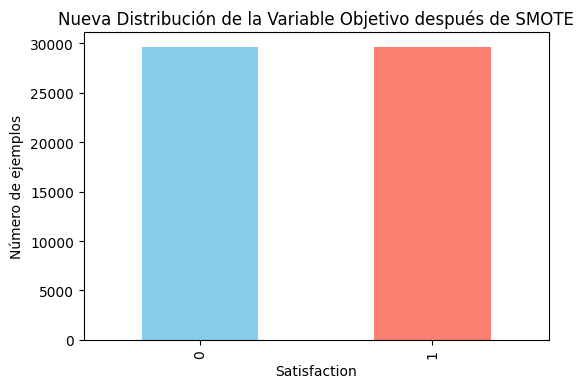

In [45]:
# Separar características y la variable objetivo
X = data_clean.drop(columns=['satisfaction'])  # Todas las columnas menos 'satisfaction'
y = data_clean['satisfaction']  # La columna 'satisfaction'

# Verificar el número de columnas antes de aplicar SMOTE
print(f"Número de columnas en X antes de SMOTE: {X.shape[1]}")

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Verificar el número de columnas después de aplicar SMOTE
print(f"Número de columnas en X_balanced después de SMOTE: {X_balanced.shape[1]}")

# Convertir X_balanced a un DataFrame para mantener las etiquetas de las columnas
X_balanced_df = pd.DataFrame(X_balanced, columns=X.columns)

# Añadir la columna de la variable objetivo 'satisfaction'
data_balanced = X_balanced_df.copy()
data_balanced['satisfaction'] = y_balanced

# Verificar la nueva distribución de la variable objetivo
nueva_distribucion = y_balanced.value_counts()
print(nueva_distribucion)

# Visualizar la nueva distribución
plt.figure(figsize=(6, 4))
nueva_distribucion.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Nueva Distribución de la Variable Objetivo después de SMOTE')
plt.xlabel('Satisfaction')
plt.ylabel('Número de ejemplos')
plt.show()

La imagen muestra la nueva distribución de la variable objetivo `satisfaction` después de aplicar SMOTE. Esta técnica ha sido utilizada para equilibrar las clases mediante la generación de ejemplos sintéticos, resultando en un número igual de observaciones para las categorías `0` (insatisfecho) y `1` (satisfecho).

## Importancia de la Generación de Datos Sintéticos

SMOTE (Synthetic Minority Over-sampling Technique) es una técnica de sobremuestreo que ayuda a superar el problema de desbalance de clases generando ejemplos sintéticos de la clase minoritaria. Aunque el desbalance inicial no era extremadamente pronunciado, la decisión de utilizar SMOTE se tomó para minimizar cualquier riesgo de sesgo en los modelos predictivos que se desarrollarán a partir de estos datos.


# Análisis de Multicolinealidad y Eliminación de Variables con VIF Alto

La multicolinealidad es un problema común en los modelos de regresión, donde dos o más variables predictoras están altamente correlacionadas, lo que puede afectar la precisión y estabilidad del modelo. Para abordar este problema, calculamos el Factor de Inflación de la Varianza (VIF) y eliminamos las variables con un VIF alto.

### Adición de una Constante y Cálculo del VIF

Se comienza añadiendo una constante al conjunto de datos, lo que es necesario para el cálculo correcto del VIF. Luego, se calcula el VIF para cada variable en el DataFrame.


In [46]:
# Añadir una constante al conjunto de datos
X = add_constant(data_balanced)

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Eliminar el VIF para la constante
vif_data = vif_data[vif_data.Variable != 'const']

# Filtrar las variables con un VIF mayor a 4
vif_alto = vif_data[vif_data["VIF"] > 4]

# Guardar los nombres de las columnas que serán eliminadas
columnas_eliminadas = vif_alto["Variable"].tolist()

# Eliminar las columnas correspondientes del DataFrame original
data_balanced = data_clean.drop(columns=columnas_eliminadas)

# Eliminar la columna 'const' del DataFrame
# data_clean = data_clean.drop(columns=['const'])

# Imprimir las variables eliminadas
print("Variables eliminadas debido a VIF alto:")
print(columnas_eliminadas)

# Verificar la estructura del DataFrame después de eliminar las variables
print("\nDataFrame después de eliminar variables con VIF mayor a 4:")
print(data_balanced.info())


Variables eliminadas debido a VIF alto:
['inflight_entertainment']

DataFrame después de eliminar variables con VIF mayor a 4:
<class 'pandas.core.frame.DataFrame'>
Index: 51855 entries, 1 to 71891
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                51855 non-null  int8 
 1   flight_distance                    51855 non-null  int16
 2   inflight_wifi_service              51855 non-null  int8 
 3   departure_arrival_time_convenient  51855 non-null  int8 
 4   ease_of_online_booking             51855 non-null  int8 
 5   gate_location                      51855 non-null  int8 
 6   food_and_drink                     51855 non-null  int8 
 7   online_boarding                    51855 non-null  int8 
 8   seat_comfort                       51855 non-null  int8 
 9   onboard_service                    51855 non-null  int8 
 10  leg_room_service    

# Exportación del DataFrame Balanceado a un Archivo CSV

Una vez que el DataFrame ha sido limpiado, balanceado y ajustado, el siguiente paso es exportarlo para su uso posterior. Esto permite guardar el conjunto de datos procesado en un archivo CSV, facilitando su acceso y reutilización en futuros análisis o modelos.

### Exportación del DataFrame `data_balanced`

In [47]:
output_path = r'C:\Users\pc-admin\Documents\Proyectos Data\Customer_Satisfaction\data_balanced.csv'
data_balanced.to_csv(output_path, index=False)